In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from keras.models import Sequential
import numpy as np
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model

In [3]:
# load WADI attack file
df_WADIi = pd.read_csv("Data_sets/WADI_attackdataLABLE.csv", header = 1)

In [4]:
df_WADIi_a = df_WADIi.iloc[:-2] # remove last two rows as they have NaN time stamp
Time_Stamp = pd.date_range(start='2017-10-09 18:00:00', periods = 172801, freq='s') # create time frame starting from 10/09 1800 to 10/11 1800 (2days)

In [5]:
df_WADIi_a['Time_Stamp'] = Time_Stamp # add new column with time stamp

c:\Users\vbvill\Desktop\SWaT\WADI\WADI.A2_19 Nov 2019\SWAT\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
#remove rows from original WADI that only have 1 unique value
for col in df_WADIi_a.columns:
    if df_WADIi_a[col].nunique() == 1:
        df_WADIi_a.drop(col, inplace=True, axis=1)

c:\Users\vbvill\Desktop\SWaT\WADI\WADI.A2_19 Nov 2019\SWAT\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
#remove rows from original WADI that have 0 values
for col in df_WADIi_a.columns:
    if df_WADIi_a[col].nunique() == 0:
        df_WADIi_a.drop(col, inplace=True, axis=1)

In [8]:
df_WADIi_a.shape

(172801, 101)

In [9]:
#create dataframe with 1FIT001 signal
df_FIT = df_WADIi_a[['Time_Stamp', '1_FIT_001_PV']]

<AxesSubplot:xlabel='Time_Stamp'>

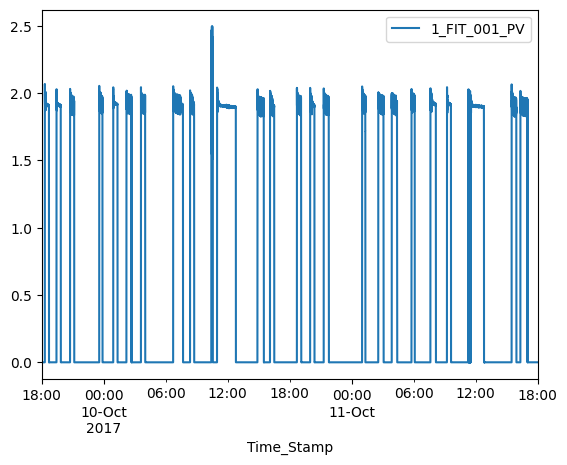

In [10]:
df_FIT.plot('Time_Stamp', '1_FIT_001_PV')

In [11]:
# choose the 'clean' training range after 10/10 1800 and everything else as test
train, test = df_FIT.loc[df_FIT['Time_Stamp'] > '2017/10/10 13:00:00'], df_FIT.loc[df_FIT['Time_Stamp'] <= '2017/10/10 13:00:00']

In [12]:
# standardize data
#scaler = StandardScaler()
#scaler1 = scaler.fit(train[['1_FIT_001_PV']])
#scaler2 = scaler.fit(test[['1_FIT_001_PV']])
#train['1_FIT_001_PV'] = scaler1.transform(train[['1_FIT_001_PV']])
#test['1_FIT_001_PV'] = scaler2.transform(test[['1_FIT_001_PV']])

train_mean = train['1_FIT_001_PV'].mean()
train_std = train['1_FIT_001_PV'].std()
train['1_FIT_001_PV'] = (train['1_FIT_001_PV']-train_mean)/train_std

test_mean = test['1_FIT_001_PV'].mean()
test_std = test['1_FIT_001_PV'].std()
test['1_FIT_001_PV'] = (test['1_FIT_001_PV']-test_mean)/test_std

c:\Users\vbvill\Desktop\SWaT\WADI\WADI.A2_19 Nov 2019\SWAT\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\Users\vbvill\Desktop\SWaT\WADI\WADI.A2_19 Nov 2019\SWAT\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
# define the number of points to go back
# function that uses sequences to creat x and y arrays

seq_size = 3600

def to_sequences(x, y, seq_size = 1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])

    return np.array(x_values), np.array(y_values)

In [14]:
trainX, trainY = to_sequences(train[['1_FIT_001_PV']], train[['1_FIT_001_PV']], seq_size)
testX, testY = to_sequences(test[['1_FIT_001_PV']], test[['1_FIT_001_PV']], seq_size)

In [15]:
model = Sequential()
model.add(LSTM(4, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

In [16]:
model.add(RepeatVector(trainX.shape[1]))

In [17]:
model.add(LSTM(4, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer = 'adam',loss = 'mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 repeat_vector (RepeatVector  (None, 3600, 4)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 3600, 4)           144       
                                                                 
 dropout_1 (Dropout)         (None, 3600, 4)           0         
                                                                 
 time_distributed (TimeDistr  (None, 3600, 1)          5         
 ibuted)                                                

In [18]:
history = model.fit(trainX, trainY, epochs=1, batch_size=120, validation_split=0.1, verbose=True)

756/756 [==============================] - 1506s 2s/step - loss: 0.3250 - val_loss: 0.1303


In [21]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis = 1)

3150/3150 [==============================] - 791s 251ms/step


(array([29536.,  1737.,  1809.,  1538.,  1590.,  1439.,  1543.,  1558.,
         1553.,  6379.,  1432.,  3633.,  9351.,  2658.,  1346.,  6839.,
         3045.,  2920.,  3049.,  1621.,  2944.,  1795.,  2195.,  2022.,
         1811.,  2163.,  1400.,  1369.,   390.,   135.]),
 array([0.06681138, 0.13773067, 0.20864997, 0.27956926, 0.35048856,
        0.42140785, 0.49232715, 0.56324644, 0.63416573, 0.70508503,
        0.77600432, 0.84692362, 0.91784291, 0.98876221, 1.0596815 ,
        1.13060079, 1.20152009, 1.27243938, 1.34335868, 1.41427797,
        1.48519726, 1.55611656, 1.62703585, 1.69795515, 1.76887444,
        1.83979374, 1.91071303, 1.98163232, 2.05255162, 2.12347091,
        2.19439021]),
 <BarContainer object of 30 artists>)

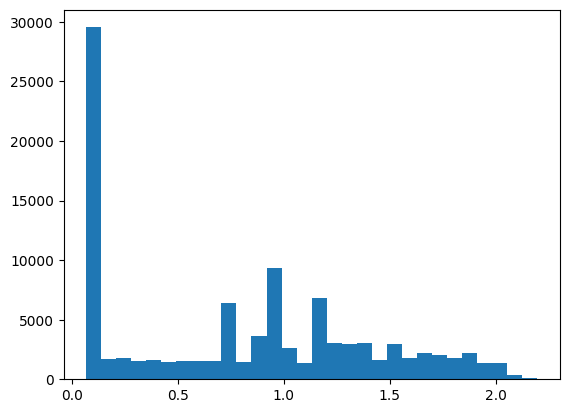

In [22]:
plt.hist(trainMAE, bins=30)

2026/2026 [==============================] - 762s 376ms/step


(array([ 3061., 14135.,   813.,   821.,  1055.,  2651.,  1232.,  1223.,
         1273.,  3831.,  1367.,  6722.,  7468.,   522.,  2259.,   464.,
          529.,   657.,  1081.,  1123.,  2228.,  2106.,  1119.,  1154.,
         1122.,  1609.,  1386.,   876.,   466.,   448.]),
 array([0.02987192, 0.1012383 , 0.17260469, 0.24397107, 0.31533746,
        0.38670384, 0.45807023, 0.52943661, 0.600803  , 0.67216938,
        0.74353577, 0.81490215, 0.88626854, 0.95763492, 1.02900131,
        1.10036769, 1.17173408, 1.24310046, 1.31446685, 1.38583323,
        1.45719962, 1.528566  , 1.59993239, 1.67129877, 1.74266516,
        1.81403154, 1.88539793, 1.95676431, 2.02813069, 2.09949708,
        2.17086346]),
 <BarContainer object of 30 artists>)

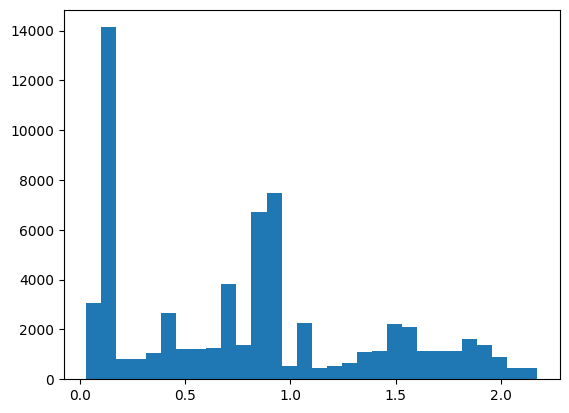

In [23]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis =1)
plt.hist(testMAE, bins=30)

In [34]:
max_trainMAE =2.1

In [35]:
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']

In [36]:
anomalies = anomaly_df.loc[anomaly_df['anomaly']==True]

In [37]:
x_timestamp = anomaly_df['Time_Stamp']
y_signal = anomaly_df['1_FIT_001_PV']
x_anomalies = anomalies['Time_Stamp']
Y_anomalies_signal = anomalies['1_FIT_001_PV']

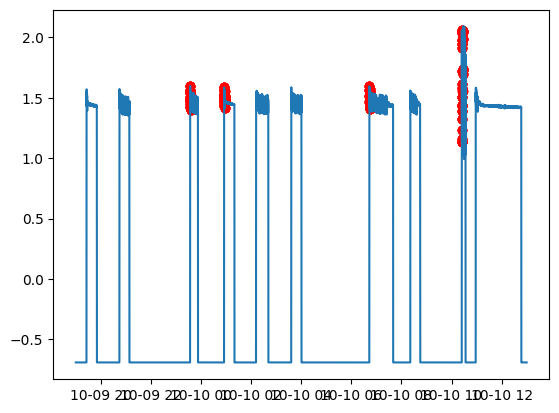

In [47]:

plt.scatter(x_anomalies,Y_anomalies_signal, color = 'r')
plt.plot(x_timestamp, y_signal)
plt.show()

In [59]:
anomalies.tail(135)

,Time_Stamp,1_FIT_001_PV,testMAE,max_trainMAE,anomaly
45894,2017-10-10 06:44:54,1.486647,2.100363,2.1,True
59076,2017-10-10 10:24:36,1.136127,2.108292,2.1,True
59077,2017-10-10 10:24:37,1.136127,2.114614,2.1,True
59078,2017-10-10 10:24:38,1.136127,2.118995,2.1,True
59079,2017-10-10 10:24:39,1.136127,2.122052,2.1,True
...,...,...,...,...,...
59208,2017-10-10 10:26:48,1.732196,2.101619,2.1,True
59209,2017-10-10 10:26:49,1.732196,2.101671,2.1,True
59210,2017-10-10 10:26:50,1.732196,2.101188,2.1,True
59211,2017-10-10 10:26:51,1.732196,2.100650,2.1,True


In [49]:
attack = df_WADIi_a[df_WADIi_a['Attack LABLE (1:No Attack, -1:Attack)']==-1]

In [54]:
attack[['1_FIT_001_PV', 'Time_Stamp']]

,1_FIT_001_PV,Time_Stamp
5103,0.000870,2017-10-09 19:25:03
5104,0.000870,2017-10-09 19:25:04
5105,0.000870,2017-10-09 19:25:05
5106,0.001254,2017-10-09 19:25:06
5107,0.001254,2017-10-09 19:25:07
...,...,...
164219,1.879540,2017-10-11 15:36:59
164220,1.848800,2017-10-11 15:37:00
164221,1.848800,2017-10-11 15:37:01
164222,1.848800,2017-10-11 15:37:02


<AxesSubplot:xlabel='Time_Stamp'>

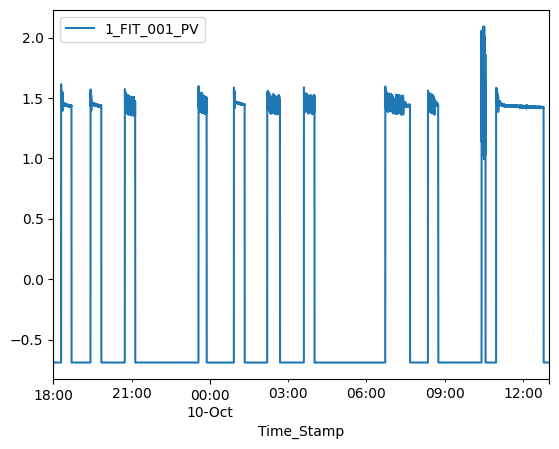

In [55]:
test.plot('Time_Stamp', '1_FIT_001_PV')

In [61]:
df_WADIi_a.shape

(172801, 101)

In [62]:
df_WADIi_a.head()

,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LT_001_PV,...,2B_AIT_004_PV,3_AIT_003_PV,3_AIT_004_PV,3_AIT_005_PV,3_FIT_001_PV,3_LT_001_PV,LEAK_DIFF_PRESSURE,TOTAL_CONS_REQUIRED_FLOW,"Attack LABLE (1:No Attack, -1:Attack)",Time_Stamp
0,1.0,10/9/17,00:00.0,164.21,0.529486,11.9972,482.48,0.331167,0.001273,48.482,...,475.488,11.528,-65.9686,0.755703,0.626306,64.3306,62.6226,0.39,1,2017-10-09 18:00:00
1,2.0,10/9/17,00:01.0,164.21,0.529486,11.9972,482.48,0.331167,0.001273,48.482,...,475.488,11.528,-65.9686,0.755703,0.626306,64.3306,62.6226,0.39,1,2017-10-09 18:00:01
2,3.0,10/9/17,00:02.0,164.21,0.529486,11.9972,482.48,0.331167,0.001273,48.482,...,475.488,11.528,-65.9686,0.755703,0.626306,64.3306,62.6226,0.39,1,2017-10-09 18:00:02
3,4.0,10/9/17,00:03.0,164.21,0.529486,11.9972,482.48,0.331167,0.001273,48.482,...,475.394,11.528,-65.9686,0.755703,0.626306,64.3306,62.6226,0.39,1,2017-10-09 18:00:03
4,5.0,10/9/17,00:04.0,164.21,0.529486,11.9972,482.48,0.331167,0.001273,48.482,...,475.394,11.528,-65.9686,0.755703,0.626306,64.3306,62.6226,0.39,1,2017-10-09 18:00:04
